In [ ]:
import sys
additional = [r"C:\Users\Yan\Desktop\Robotic hand\Scripts\Online Server\core\AI",r"C:\Users\Yan\Desktop\Robotic hand\Scripts\Online Server"]
for p in additional:
    if not p in sys.path:
        sys.path.append(p)

print(sys.path)

In [ ]:
# Extract convolution kernels weights

from VoxelModel.VoxelArchitecture import model, CNN_Block, Head_Block, CNN

conv_weights = []

for name, param in model.named_parameters():
    # print(name, parameters)
    if name.endswith(".conv.weight"):
        print("Added name: " + name)
        conv_weights.append((name, param))


In [ ]:
# load a small dataset
import os
from torch.utils.data import DataLoader, Dataset
import torch
import numpy as np
import csv
from torch import nn
from torchvision import datasets, transforms
import time
import copy


dataset_path = r"C:\Users\Yan\Desktop\Robotic hand\Scripts\Voxelization\cubes"
targets_path = r"C:\Users\Yan\Desktop\PositionBonesRight.csv"

def getCoords(dir_path):
  files = os.listdir(dir_path)
  coords = []
  for file_name in files:
    with open(dir_path + "/" + file_name) as file:
      coords.append((np.loadtxt(file, dtype=np.int32), int(file_name.split("_")[2])))

  return coords

def readTargets(targets_path):
  targets = {}
  with open(targets_path) as f:
    file_reader = csv.reader(f)
    first = True
    for row in file_reader:
      if first:
        first = False
        continue
      handPose = []
      for col in row[1:]:
        if col != '':
          handPose.append((float(col)%360)/360)
      targets[int(float(row[0]))] = handPose
    f.close()
  return targets

def insertVoxels(cubes, voxels):
  # insert voxels into cubes
  for i in range(len(voxels)):
    coords_target = voxels[i]
    for coord in coords_target[0]:
      cubes[i,0][tuple(np.array(coord))] = 1
  return cubes

class VoxelsDataset(Dataset):
  def __init__(self, dataset_path, targets_path):
    self.dataset_path = dataset_path

    self.targets_path = targets_path

    # get voxels and target indices
    self.voxels_targets_ind = getCoords(dataset_path)

    # get cubes in zeros
    self.cubes = np.zeros((len(self.voxels_targets_ind),1,25,25,25), np.bool_)

    # get targets from csv
    self.targets = readTargets(targets_path)

    # # insert voxels into cubes
    self.cubes = insertVoxels(self.cubes, self.voxels_targets_ind)


  def __len__(self):
    return self.cubes.shape[0]

  def __getitem__(self,ind):

    return torch.tensor(self.cubes[ind], dtype=torch.float32), torch.tensor(self.targets[self.voxels_targets_ind[ind][1]][54:], dtype=torch.float32)


In [ ]:
voxelDataset = VoxelsDataset(dataset_path, targets_path)

In [18]:
from torch import nn
from VoxelModel.VoxelArchitecture import model, CNN_Block, Head_Block, CNN

first = True

CNN_BLOCKS = []

for x in model.hidden_layers.modules():
    if type(x) == CNN_Block:
        CNN_BLOCKS.append(x)


(12, 12, 12)


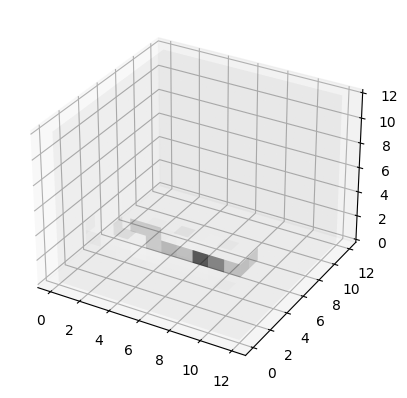

(12, 12, 12)


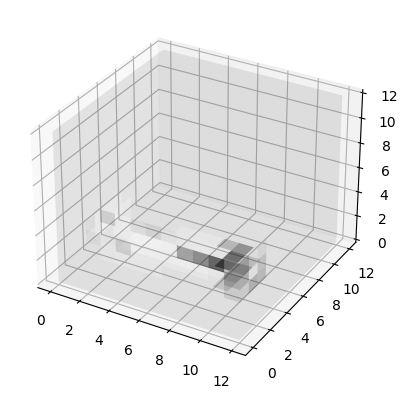

(12, 12, 12)


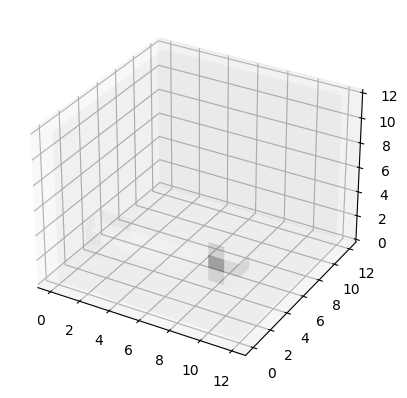

(12, 12, 12)


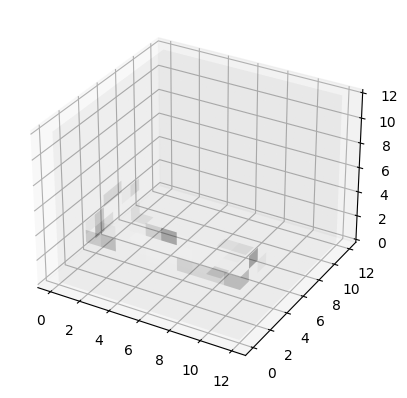

(12, 12, 12)


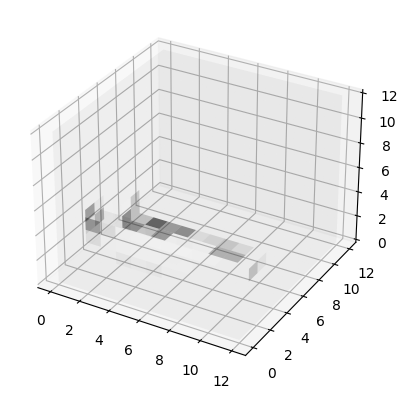

(12, 12, 12)


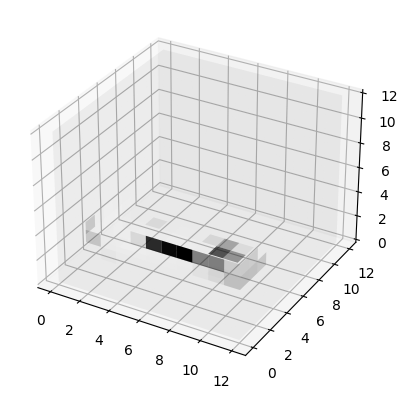

(12, 12, 12)


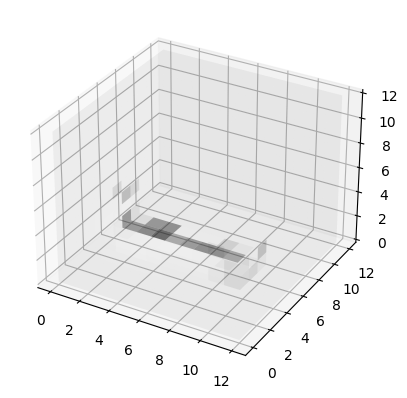

(12, 12, 12)


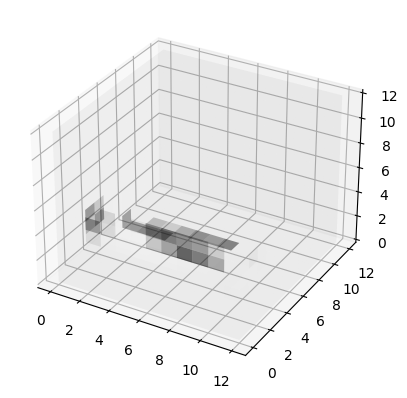

(12, 12, 12)


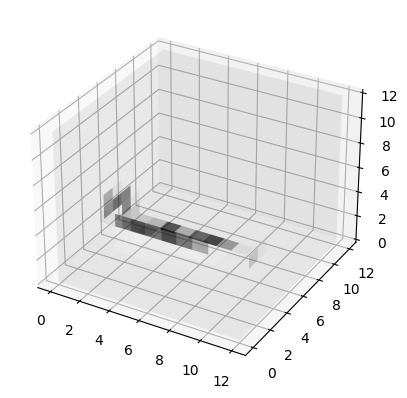

(12, 12, 12)


ValueError: Invalid RGBA argument: 0.0

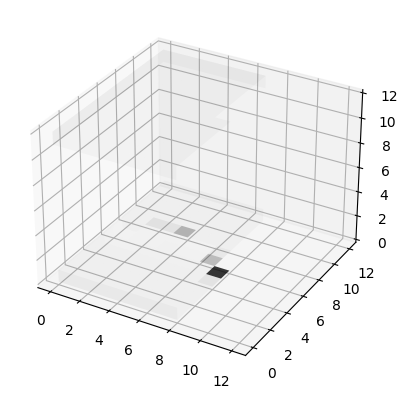

In [58]:
import matplotlib.pyplot as plt

def plot_cube(cube):
    zerod_cube = -np.min(cube) + cube

    normalized_cube = zerod_cube / 2

     # Control Transparency
    alpha = 0.9
    
    axes = list(cube.shape)

    # Control colour
    colors = np.empty(axes + [4] , dtype=np.float32)

    # Get all indices and values using ndenumerate
    indices_and_values = list(np.ndenumerate(normalized_cube))

    # Print the list of indices and values
    for (index, value) in indices_and_values:
        b = [0,0,0,(value)]
        colors[index] = b
    
    # Plot figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Voxels is used to customizations of the
    # sizes, positions and colors.
    ax.voxels(np.ones(cube.shape), facecolors=colors)

    plt.show()
for i in range(len(outs)):
    for j in range(len(outs[i])):
        print(outs[i][j].detach().numpy().shape)
        plot_cube(outs[i][j].detach().numpy())

In [19]:
print(CNN_BLOCKS)

[CNN_Block(
  (conv): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=same)
  (act): LeakyReLU(negative_slope=0.01)
  (max_pool): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
), CNN_Block(
  (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (act): LeakyReLU(negative_slope=0.01)
  (max_pool): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
), CNN_Block(
  (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (act): LeakyReLU(negative_slope=0.01)
  (max_pool): MaxPool3d(kernel_size=(2, 2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
), CNN_Block(
  (conv): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (act): LeakyReLU(negative_slope=0.01)
  (max_pool): MaxPool3d(kernel_size=(2, 2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
), CNN_Block(
  (conv): Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1),

In [24]:
sample_x, sample_y = voxelDataset[0]

outs = []

out = sample_x

for CNN_BLOCK in CNN_BLOCKS:
    out = CNN_BLOCK(out)
    outs.append(out)

print(sample_x.size())
for out in outs:
    print(out.size())

torch.Size([1, 25, 25, 25])
torch.Size([16, 12, 12, 12])
torch.Size([32, 6, 6, 6])
torch.Size([64, 5, 5, 5])
torch.Size([32, 4, 4, 4])
torch.Size([16, 3, 3, 3])


In [ ]:
for i in range(len(conv_weights)):
    print(conv_weights[i][0], ",  Size is : " + str(conv_weights[i][1].size()))


In [ ]:
def load_cube_from_voxel_indices(voxel_indices, shape):
    cube = np.zeros((shape))
    
    for index in voxel_indices:
        cube[tuple(index)] = 1
    
    return cube

In [ ]:
# create voxels

import open3d as o3d
import numpy as np

voxels_kernels = []

for j in range(len(conv_weights)):
    tens = conv_weights[i][1]
    voxel_sets = []
    for n in range(tens.size(dim=0)):
        kernel_set = tens[n]
        voxel_chanel_sets = []
        for kernel in kernel_set:
            pcd = o3d.geometry.PointCloud()
            num = kernel.detach().numpy().reshape(-1,3)
            pcd.points = o3d.utility.Vector3dVector(num)
            voxel = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, 0.5)
            voxel_chanel_sets.append(voxel)
        voxel_sets.append(voxel_chanel_sets)
    voxels_kernels.append(voxel_sets)

cubes = []

for voxel_sets in voxels_kernels:
    cubes_sets = []
    print("- Num Channel sets " + str(len(voxel_sets)))
    for voxel_chanel_sets in voxel_sets:
        channel_sets_cubes = []
        print("--- Num channels in set   " + str(len(voxel_chanel_sets)))
        for voxel in voxel_chanel_sets:
            voxel_indices = [voxel.grid_index for voxel in voxel.get_voxels()]
            cube = load_cube_from_voxel_indices(voxel_indices)
            channel_sets_cubes.append(cube)
            print("----- Voxel amount   " + str(len(voxel.get_voxels())))
        cubes_sets.append(channel_sets_cubes)
    cubes.append(cubes_sets)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

figure_folder = r"C:\Users\Yan\Desktop\Robotic hand\Scripts\VisualizeModelsFeatures\figures"

def plot_channel_kernels(cubes, n_set, n_channel):
    # def plot_kernels
    fig = plt.figure(figsize=(10,20))

    fig.suptitle("Set number: " + str(n_set) + " Channel set number: " + str(n_channel))
    num_cubes_to_show = len(cubes[n_set][n_channel])

    ncols=2; nrows= int(num_cubes_to_show // 2) + 1

    spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, width_ratios=[5,5])

    for i in range(num_cubes_to_show):
        cube = cubes[n_set][n_channel][i]
        axes = [5,5,5]

        colors = np.empty(axes + [4], dtype=np.float32)
        alpha = 0.9
        colors[:] = [1, 0, 0, alpha]  # red

        row = int(i / ncols)
        col = i % ncols

        ax = fig.add_subplot(spec[row,col], projection="3d")
        ax.set_title("Fig. " + str(i))
        data = cube
        ax.voxels(data)
    # plt.savefig(figure_folder + r"\\" + "S_N " + str(n_set) + " C_N " + str(n_channel))
    plt.show()

# for i in range(len(cubes)):
#     for j in range(len(cubes[i])):
#         plot_channel_kernels(cubes,i,j)
plot_channel_kernels(cubes,0,0)